# Question - 01

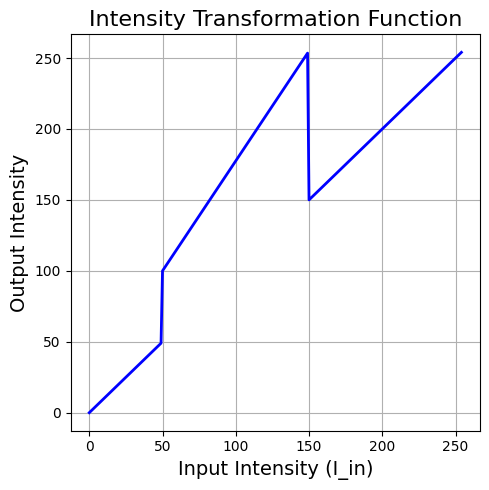

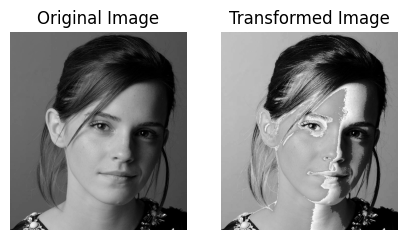

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

# Load the grayscale image
image = io.imread('./a1images/a1images/emma.jpg', as_gray=True)

image_scaled = (image * 255).astype(np.uint8)

def transform_intensity(I_in):
    if I_in < 50:
        return I_in
    elif I_in < 150:
        return 100 + (255-100)/(100) * (I_in-50)
    else:
        return I_in

# Aply the transformation
transformed_image = np.vectorize(transform_intensity)(image_scaled)

# Ensure the output intensities are within [0, 255]
transformed_image = np.clip(transformed_image, 0, 255).astype(np.uint8)

transformed_image_rescaled = transformed_image / 255.0
input_intensities = np.arange(0, 255)

# Apply transformation
output_intensities = np.array([transform_intensity(i) for i in input_intensities])

# Plot the transformation curve
plt.figure(figsize=(5, 5))
plt.plot(input_intensities, output_intensities, color='blue', linewidth=2)
plt.title('Intensity Transformation Function', fontsize=16)
plt.xlabel('Input Intensity (I_in)', fontsize=14)
plt.ylabel('Output Intensity', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

# Display the original and transformed images
plt.figure(figsize=(5, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(transformed_image_rescaled, cmap='gray')
plt.title('Transformed Image')
plt.axis('off')

plt.show()


# Question - 02

Starting improved segmentation...
✓ Improved brain mask created
✓ Initial tissue segmentation complete
✓ CSF removal complete
✓ Gray matter refinement complete
✓ Final cleaning complete


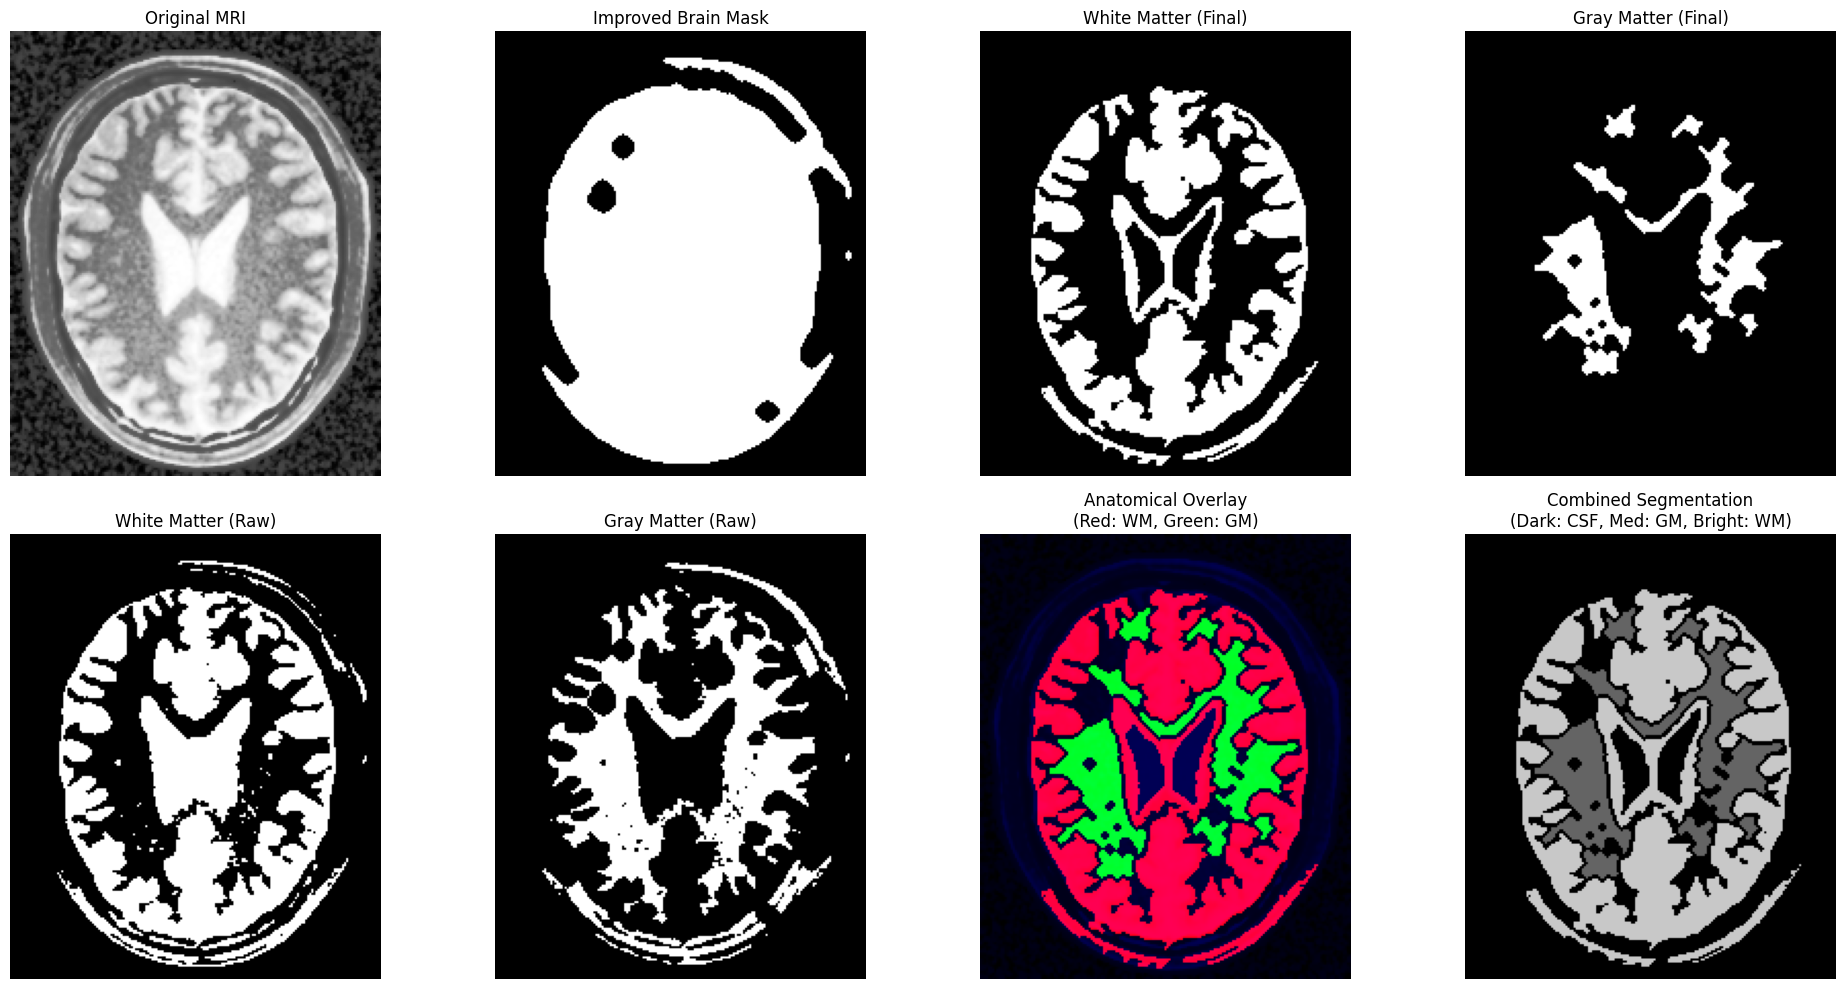


Improved Segmentation Statistics:
Total brain pixels: 21041
White matter: 10374 pixels (49.3%)
Gray matter: 3601 pixels (17.1%)
Other tissue (CSF, etc.): 7066 pixels (33.6%)
✓ Improved segmentation completed successfully!


In [34]:
import cv2
import numpy as np
from scipy import ndimage
from skimage import filters, morphology, segmentation
import matplotlib.pyplot as plt

def improved_brain_mask(img):
    """
    Create a more accurate brain mask that excludes skull and CSF
    """
    # Apply strong Gaussian blur to reduce texture
    img_blur = cv2.GaussianBlur(img, (7, 7), 0)
    
    # Use multiple thresholding to separate regions
    # First, get a rough brain region
    _, rough_mask = cv2.threshold(img_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Find the largest connected component (should be the brain)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(rough_mask, connectivity=8)
    
    # Get the largest component (excluding background)
    if num_labels > 1:
        largest_label = np.argmax(stats[1:, cv2.CC_STAT_AREA]) + 1
        brain_mask = (labels == largest_label).astype(np.uint8) * 255
    else:
        brain_mask = rough_mask
    
    # Morphological operations to smooth the mask
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    brain_mask = cv2.morphologyEx(brain_mask, cv2.MORPH_CLOSE, kernel)
    brain_mask = cv2.morphologyEx(brain_mask, cv2.MORPH_OPEN, kernel)
    
    # Erode slightly to remove skull remnants
    kernel_small = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    brain_mask = cv2.erode(brain_mask, kernel_small, iterations=2)
    
    return brain_mask

def improved_tissue_segmentation(img, brain_mask):
    """
    Improved segmentation using histogram analysis and morphological constraints
    """
    # Apply brain mask
    brain_only = cv2.bitwise_and(img, brain_mask)
    brain_pixels = brain_only[brain_mask > 0]
    
    # Compute histogram to identify peaks
    hist, bins = np.histogram(brain_pixels, bins=256, range=(0, 256))
    
    # Smooth histogram to find peaks
    hist_smooth = ndimage.gaussian_filter1d(hist.astype(float), sigma=2)
    
    # Find local maxima (tissue peaks)
    peaks = []
    for i in range(1, len(hist_smooth)-1):
        if hist_smooth[i] > hist_smooth[i-1] and hist_smooth[i] > hist_smooth[i+1]:
            if hist_smooth[i] > np.max(hist_smooth) * 0.1:  # Only significant peaks
                peaks.append((bins[i], hist_smooth[i]))
    
    # Sort peaks by intensity
    peaks.sort(key=lambda x: x[0])
    
    if len(peaks) >= 2:
        # Use the two main peaks for segmentation
        gray_peak = peaks[0][0]  # Lower intensity peak (gray matter)
        white_peak = peaks[-1][0]  # Higher intensity peak (white matter)
        
        # Calculate thresholds between peaks
        valley_threshold = (gray_peak + white_peak) / 2
        
        # Create initial masks
        white_matter_mask = (brain_only > valley_threshold) & (brain_mask > 0)
        gray_matter_mask = (brain_only > gray_peak * 0.7) & (brain_only <= valley_threshold) & (brain_mask > 0)
    else:
        # Fallback to statistical method
        mean_val = np.mean(brain_pixels)
        std_val = np.std(brain_pixels)
        
        white_threshold = mean_val + 0.3 * std_val
        gray_lower = mean_val - 0.5 * std_val
        
        white_matter_mask = (brain_only > white_threshold) & (brain_mask > 0)
        gray_matter_mask = (brain_only > gray_lower) & (brain_only <= white_threshold) & (brain_mask > 0)
    
    return white_matter_mask.astype(np.uint8) * 255, gray_matter_mask.astype(np.uint8) * 255

def remove_csf_ventricles(white_matter_mask, gray_matter_mask, original_img, brain_mask):
    """
    Remove CSF/ventricles that might be misclassified as white matter
    """
    # CSF/ventricles are typically very bright and have specific shape characteristics
    brain_only = cv2.bitwise_and(original_img, brain_mask)
    
    # Find very bright regions (potential CSF)
    very_bright_threshold = np.percentile(brain_only[brain_mask > 0], 95)
    potential_csf = brain_only > very_bright_threshold
    
    # Analyze shape characteristics of bright regions
    contours, _ = cv2.findContours(potential_csf.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    csf_mask = np.zeros_like(white_matter_mask)
    
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 50:  # Minimum area for ventricles
            # Calculate shape properties
            perimeter = cv2.arcLength(contour, True)
            if perimeter > 0:
                circularity = 4 * np.pi * area / (perimeter * perimeter)
                
                # CSF regions are often more circular/compact than white matter tracts
                if circularity > 0.3:  # Relatively circular
                    cv2.fillPoly(csf_mask, [contour], 255)
    
    # Remove CSF regions from white matter mask
    white_matter_cleaned = cv2.bitwise_and(white_matter_mask, cv2.bitwise_not(csf_mask))
    
    return white_matter_cleaned, gray_matter_mask

def refine_gray_matter(gray_matter_mask, white_matter_mask, brain_mask, original_img):
    """
    Refine gray matter segmentation to be more anatomically consistent
    """
    # Gray matter should form a continuous cortical ribbon
    # Use distance transform to ensure gray matter surrounds white matter
    
    # Distance from white matter
    white_dist = cv2.distanceTransform(cv2.bitwise_not(white_matter_mask), cv2.DIST_L2, 5)
    
    # Distance from brain boundary
    brain_boundary = cv2.bitwise_xor(brain_mask, cv2.erode(brain_mask, np.ones((3,3), np.uint8)))
    boundary_dist = cv2.distanceTransform(cv2.bitwise_not(brain_boundary), cv2.DIST_L2, 5)
    
    # Gray matter should be in an intermediate zone
    brain_only = cv2.bitwise_and(original_img, brain_mask)
    
    # Create improved gray matter mask
    improved_gray = np.zeros_like(gray_matter_mask)
    
    # Conditions for gray matter:
    # 1. Within brain mask
    # 2. Not white matter
    # 3. Appropriate distance from white matter (cortical thickness)
    # 4. Appropriate intensity range
    
    mean_intensity = np.mean(brain_only[brain_mask > 0])
    
    conditions = (
        (brain_mask > 0) &
        (white_matter_mask == 0) &
        (white_dist > 2) & (white_dist < 20) &  # Typical cortical thickness range
        (boundary_dist > 3) &  # Not too close to skull
        (brain_only > mean_intensity * 0.4) & (brain_only < mean_intensity * 1.2)
    )
    
    improved_gray[conditions] = 255
    
    # Morphological cleaning
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    improved_gray = cv2.morphologyEx(improved_gray, cv2.MORPH_CLOSE, kernel)
    improved_gray = cv2.morphologyEx(improved_gray, cv2.MORPH_OPEN, kernel)
    
    return improved_gray

def advanced_segmentation_pipeline(img):
    """
    Complete improved segmentation pipeline
    """
    print("Starting improved segmentation...")
    
    # Step 1: Improved brain mask
    brain_mask = improved_brain_mask(img)
    print("✓ Improved brain mask created")
    
    # Step 2: Initial tissue segmentation
    white_matter_raw, gray_matter_raw = improved_tissue_segmentation(img, brain_mask)
    print("✓ Initial tissue segmentation complete")
    
    # Step 3: Remove CSF/ventricles from white matter
    white_matter_clean, gray_matter_clean = remove_csf_ventricles(
        white_matter_raw, gray_matter_raw, img, brain_mask
    )
    print("✓ CSF removal complete")
    
    # Step 4: Refine gray matter segmentation
    gray_matter_refined = refine_gray_matter(gray_matter_clean, white_matter_clean, brain_mask, img)
    print("✓ Gray matter refinement complete")
    
    # Step 5: Final morphological cleaning
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
    
    white_matter_final = cv2.morphologyEx(white_matter_clean, cv2.MORPH_OPEN, kernel)
    white_matter_final = morphology.remove_small_objects(
        white_matter_final.astype(bool), min_size=100
    ).astype(np.uint8) * 255
    
    gray_matter_final = cv2.morphologyEx(gray_matter_refined, cv2.MORPH_OPEN, kernel)
    gray_matter_final = morphology.remove_small_objects(
        gray_matter_final.astype(bool), min_size=50
    ).astype(np.uint8) * 255
    
    print("✓ Final cleaning complete")
    
    return {
        'brain_mask': brain_mask,
        'white_matter': white_matter_final,
        'gray_matter': gray_matter_final,
        'white_matter_raw': white_matter_raw,
        'gray_matter_raw': gray_matter_raw
    }

def visualize_improved_results(original, results):
    """
    Visualize the improved segmentation results
    """
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    
    # Row 1: Original processing steps
    axes[0, 0].imshow(original, cmap='gray')
    axes[0, 0].set_title('Original MRI', fontsize=12)
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(results['brain_mask'], cmap='gray')
    axes[0, 1].set_title('Improved Brain Mask', fontsize=12)
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(results['white_matter'], cmap='gray')
    axes[0, 2].set_title('White Matter (Final)', fontsize=12)
    axes[0, 2].axis('off')
    
    axes[0, 3].imshow(results['gray_matter'], cmap='gray')
    axes[0, 3].set_title('Gray Matter (Final)', fontsize=12)
    axes[0, 3].axis('off')
    
    # Row 2: Comparisons and overlays
    axes[1, 0].imshow(results['white_matter_raw'], cmap='gray')
    axes[1, 0].set_title('White Matter (Raw)', fontsize=12)
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(results['gray_matter_raw'], cmap='gray')
    axes[1, 1].set_title('Gray Matter (Raw)', fontsize=12)
    axes[1, 1].axis('off')
    
    # Anatomical overlay
    overlay = np.zeros((original.shape[0], original.shape[1], 3), dtype=np.uint8)
    overlay[:,:,0] = results['white_matter']  # Red channel
    overlay[:,:,1] = results['gray_matter']   # Green channel
    overlay[:,:,2] = original // 3            # Blue channel (background)
    
    axes[1, 2].imshow(overlay)
    axes[1, 2].set_title('Anatomical Overlay\n(Red: WM, Green: GM)', fontsize=12)
    axes[1, 2].axis('off')
    
    # Combined segmentation with proper intensity levels
    combined = np.zeros_like(original)
    combined[results['gray_matter'] > 0] = 100   # Gray matter - medium gray
    combined[results['white_matter'] > 0] = 200  # White matter - bright
    combined = cv2.bitwise_and(combined, results['brain_mask'])  # Only within brain
    
    axes[1, 3].imshow(combined, cmap='gray', vmin=0, vmax=255)
    axes[1, 3].set_title('Combined Segmentation\n(Dark: CSF, Med: GM, Bright: WM)', fontsize=12)
    axes[1, 3].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    brain_pixels = np.sum(results['brain_mask'] > 0)
    white_pixels = np.sum(results['white_matter'] > 0)
    gray_pixels = np.sum(results['gray_matter'] > 0)
    
    print(f"\nImproved Segmentation Statistics:")
    print(f"Total brain pixels: {brain_pixels}")
    print(f"White matter: {white_pixels} pixels ({white_pixels/brain_pixels*100:.1f}%)")
    print(f"Gray matter: {gray_pixels} pixels ({gray_pixels/brain_pixels*100:.1f}%)")
    print(f"Other tissue (CSF, etc.): {brain_pixels-white_pixels-gray_pixels} pixels ({(brain_pixels-white_pixels-gray_pixels)/brain_pixels*100:.1f}%)")

# Main function for improved processing
def process_brain_mri_improved(image_path):
    """
    Main function using the improved pipeline
    """
    # Load and preprocess image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Could not load image from {image_path}")
    
    # Apply light preprocessing
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.equalizeHist(img)
    
    # Run improved segmentation
    results = advanced_segmentation_pipeline(img)
    results['original'] = img
    
    # Visualize results
    visualize_improved_results(img, results)
    
    # Save results
    cv2.imwrite('improved_brain_mask.png', results['brain_mask'])
    cv2.imwrite('improved_white_matter.png', results['white_matter'])
    cv2.imwrite('improved_gray_matter.png', results['gray_matter'])
    
    return results

# Example usage
if __name__ == "__main__":
    try:
        # Replace with your image path
        image_path = './a1images/a1images/brain_proton_density_slice.png'
        results = process_brain_mri_improved(image_path)
        print("✓ Improved segmentation completed successfully!")
        
    except Exception as e:
        print(f"Error: {e}")
        print("Please check that your image path is correct.")

Loading and preprocessing image...
✓ Enhanced preprocessing complete
✓ Precise brain mask created
✓ Multi-class tissue segmentation complete
✓ CSF refinement and ventricle identification complete
✓ White matter refinement and corpus callosum identification complete
✓ Gray matter refinement complete


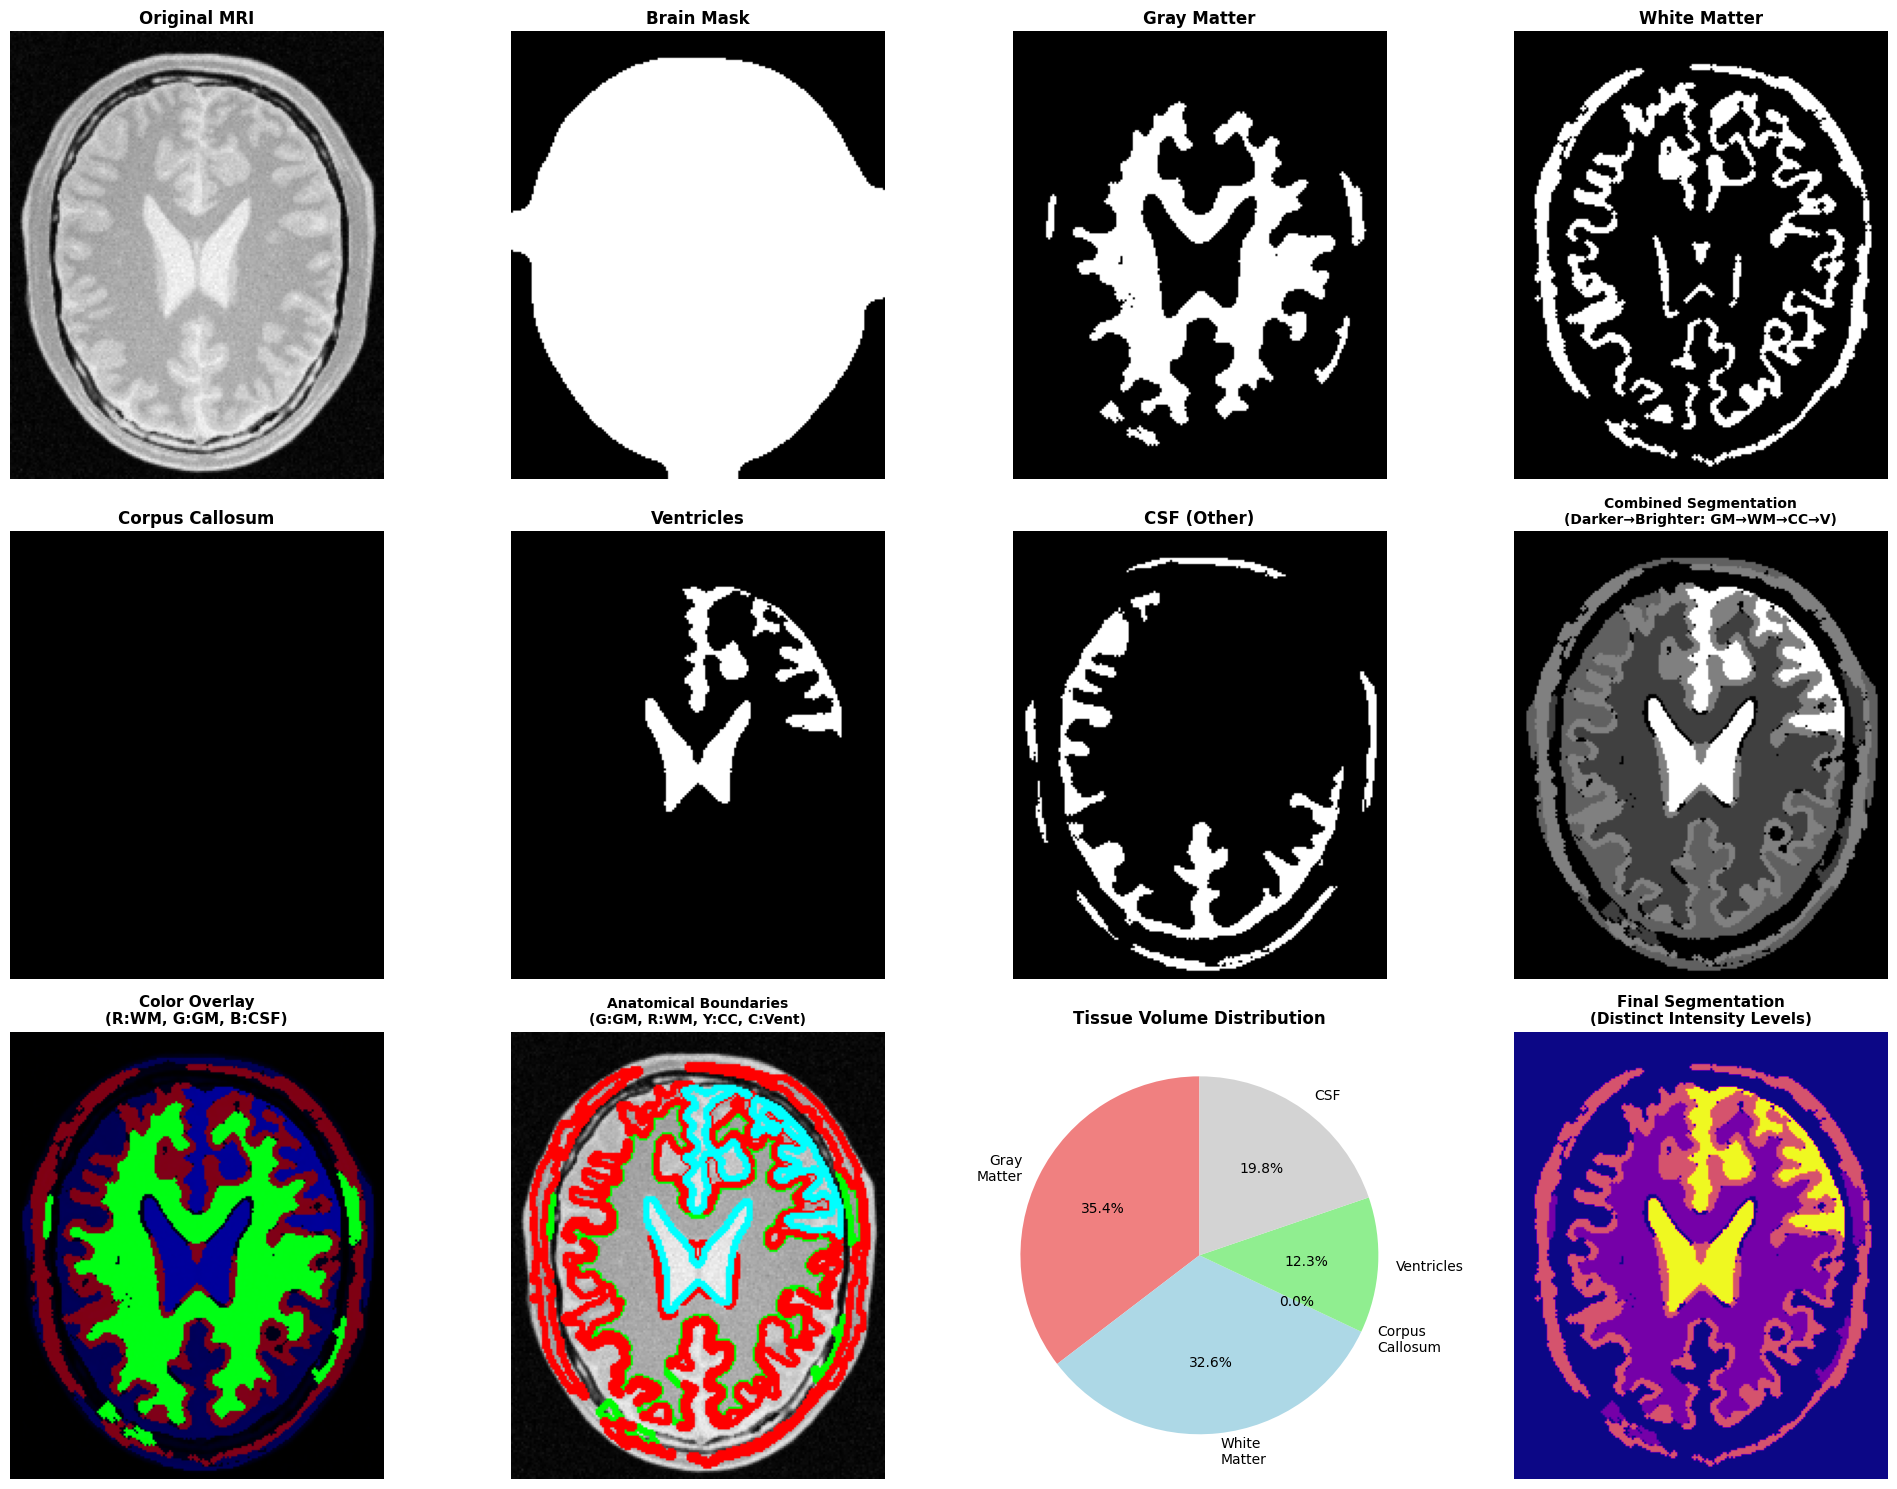


DETAILED BRAIN SEGMENTATION RESULTS
Total brain area: 27316 pixels
Gray Matter: 7972 pixels (29.2%)
White Matter: 7344 pixels (26.9%)
Corpus Callosum: 0 pixels (0.0%)
Ventricles: 2763 pixels (10.1%)
Other CSF: 4452 pixels (16.3%)
✓ Saved brain_mask.png
✓ Saved gray_matter.png
✓ Saved white_matter.png
✓ Saved corpus_callosum.png
✓ Saved ventricles.png
✓ Saved csf.png
✓ Saved combined_segmentation.png

🎉 Detailed brain segmentation completed successfully!
All individual structure masks have been saved as separate files.


In [35]:
import cv2
import numpy as np
from scipy import ndimage
from skimage import filters, morphology, segmentation, measure
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def enhanced_preprocessing(img):
    """
    Enhanced preprocessing for clearer tissue distinction
    """
    # Apply bilateral filter to preserve edges while smoothing
    img_filtered = cv2.bilateralFilter(img, 9, 75, 75)
    
    # Enhance contrast using CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_enhanced = clahe.apply(img_filtered)
    
    # Apply unsharp masking to enhance tissue boundaries
    gaussian = cv2.GaussianBlur(img_enhanced, (0, 0), 2.0)
    img_sharp = cv2.addWeighted(img_enhanced, 1.5, gaussian, -0.5, 0)
    
    return img_sharp

def create_precise_brain_mask(img):
    """
    Create a very precise brain mask excluding skull, scalp, and background
    """
    # Multi-level Otsu thresholding
    blur = cv2.GaussianBlur(img, (5, 5), 0)
    
    # First threshold to separate brain from background
    _, thresh1 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Find largest connected component
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh1, connectivity=8)
    if num_labels > 1:
        largest_idx = np.argmax(stats[1:, cv2.CC_STAT_AREA]) + 1
        brain_mask = (labels == largest_idx).astype(np.uint8) * 255
    else:
        brain_mask = thresh1
    
    # Refine mask using morphological operations
    kernel_large = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    kernel_small = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    
    # Close small gaps
    brain_mask = cv2.morphologyEx(brain_mask, cv2.MORPH_CLOSE, kernel_large)
    
    # Remove skull artifacts by erosion followed by dilation
    brain_mask = cv2.erode(brain_mask, kernel_small, iterations=3)
    brain_mask = cv2.dilate(brain_mask, kernel_small, iterations=2)
    
    # Fill any remaining holes
    brain_mask = ndimage.binary_fill_holes(brain_mask).astype(np.uint8) * 255
    
    return brain_mask

def advanced_tissue_segmentation(img, brain_mask):
    """
    Advanced multi-class tissue segmentation using intensity analysis and spatial constraints
    """
    # Extract brain-only pixels
    brain_region = cv2.bitwise_and(img, brain_mask)
    brain_pixels = brain_region[brain_mask > 0]
    
    # Perform K-means clustering with 4 classes: Background, CSF, Gray Matter, White Matter
    brain_coords = np.column_stack(np.where(brain_mask > 0))
    brain_intensities = brain_pixels.reshape(-1, 1)
    
    # Add spatial information to improve segmentation
    spatial_weight = 0.1
    features = np.column_stack([
        brain_intensities.flatten(),
        brain_coords[:, 0] * spatial_weight,  # Y coordinate
        brain_coords[:, 1] * spatial_weight   # X coordinate
    ])
    
    # K-means with 4 clusters
    kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
    labels = kmeans.fit_predict(features)
    
    # Create label image
    label_image = np.zeros_like(img)
    label_image[brain_mask > 0] = labels + 1
    
    # Identify clusters by intensity
    cluster_means = []
    for i in range(4):
        cluster_pixels = brain_pixels[labels == i]
        if len(cluster_pixels) > 0:
            cluster_means.append((i, np.mean(cluster_pixels)))
    
    # Sort clusters by intensity
    cluster_means.sort(key=lambda x: x[1])
    
    # Assign tissue types based on intensity ranking
    csf_label = cluster_means[3][0] + 1  # Brightest - CSF/Ventricles
    white_matter_label = cluster_means[2][0] + 1  # Second brightest - White Matter
    gray_matter_label = cluster_means[1][0] + 1   # Third brightest - Gray Matter
    background_label = cluster_means[0][0] + 1    # Darkest - Background/Low intensity
    
    # Create individual tissue masks
    csf_mask = (label_image == csf_label).astype(np.uint8) * 255
    white_matter_mask = (label_image == white_matter_label).astype(np.uint8) * 255
    gray_matter_mask = (label_image == gray_matter_label).astype(np.uint8) * 255
    
    return csf_mask, white_matter_mask, gray_matter_mask

def refine_csf_ventricles(csf_mask, img):
    """
    Refine CSF segmentation to identify ventricles and remove artifacts
    """
    # Analyze connected components to identify ventricles
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(csf_mask, connectivity=8)
    
    refined_csf = np.zeros_like(csf_mask)
    ventricles = np.zeros_like(csf_mask)
    
    for i in range(1, num_labels):
        component = (labels == i).astype(np.uint8) * 255
        area = stats[i, cv2.CC_STAT_AREA]
        
        if area > 50:  # Minimum size for significant CSF regions
            # Calculate shape properties
            contours, _ = cv2.findContours(component, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if contours:
                contour = contours[0]
                area_contour = cv2.contourArea(contour)
                perimeter = cv2.arcLength(contour, True)
                
                if perimeter > 0:
                    circularity = 4 * np.pi * area_contour / (perimeter * perimeter)
                    
                    # Check if it's likely a ventricle (central location + appropriate size)
                    center_y, center_x = centroids[i]
                    img_center_y, img_center_x = img.shape[0] // 2, img.shape[1] // 2
                    distance_from_center = np.sqrt((center_y - img_center_y)**2 + (center_x - img_center_x)**2)
                    
                    if distance_from_center < min(img.shape) * 0.3 and area > 100:
                        # Likely ventricle
                        ventricles = cv2.bitwise_or(ventricles, component)
                    else:
                        # Other CSF
                        refined_csf = cv2.bitwise_or(refined_csf, component)
    
    return refined_csf, ventricles

def refine_white_matter(white_matter_mask, gray_matter_mask, brain_mask, img):
    """
    Refine white matter to identify major structures like corpus callosum
    """
    # Apply morphological opening to separate connected structures
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    white_matter_opened = cv2.morphologyEx(white_matter_mask, cv2.MORPH_OPEN, kernel)
    
    # Identify major white matter structures
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(white_matter_opened, connectivity=8)
    
    corpus_callosum = np.zeros_like(white_matter_mask)
    other_white_matter = np.zeros_like(white_matter_mask)
    
    for i in range(1, num_labels):
        component = (labels == i).astype(np.uint8) * 255
        area = stats[i, cv2.CC_STAT_AREA]
        
        if area > 30:  # Minimum size
            # Get bounding box
            x, y, w, h = stats[i, cv2.CC_STAT_LEFT], stats[i, cv2.CC_STAT_TOP], stats[i, cv2.CC_STAT_WIDTH], stats[i, cv2.CC_STAT_HEIGHT]
            aspect_ratio = max(w, h) / min(w, h)
            
            # Check if it could be corpus callosum (central, horizontal structure)
            center_y = y + h // 2
            img_center_y = img.shape[0] // 2
            
            # Corpus callosum is typically in upper-middle part of brain and elongated
            if (center_y < img_center_y * 0.8 and 
                aspect_ratio > 2 and 
                area > 100 and
                x < img.shape[1] * 0.8 and (x + w) > img.shape[1] * 0.2):
                corpus_callosum = cv2.bitwise_or(corpus_callosum, component)
            else:
                other_white_matter = cv2.bitwise_or(other_white_matter, component)
    
    return corpus_callosum, other_white_matter

def refine_gray_matter(gray_matter_mask, white_matter_mask, brain_mask):
    """
    Refine gray matter to ensure it forms proper cortical structures
    """
    # Gray matter should form a continuous ribbon around white matter
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    
    # Clean up the mask
    gray_cleaned = cv2.morphologyEx(gray_matter_mask, cv2.MORPH_OPEN, kernel)
    gray_cleaned = cv2.morphologyEx(gray_cleaned, cv2.MORPH_CLOSE, kernel)
    
    # Ensure gray matter doesn't overlap with white matter
    gray_cleaned = cv2.bitwise_and(gray_cleaned, cv2.bitwise_not(white_matter_mask))
    
    # Remove small isolated regions
    gray_cleaned = morphology.remove_small_objects(gray_cleaned.astype(bool), min_size=50).astype(np.uint8) * 255
    
    return gray_cleaned

def create_detailed_segmentation_map(results):
    """
    Create a detailed segmentation map with different intensity values for each structure
    """
    height, width = results['brain_mask'].shape
    segmentation_map = np.zeros((height, width), dtype=np.uint8)
    
    # Assign different intensity values to each structure
    segmentation_map[results['gray_matter'] > 0] = 64      # Dark gray for gray matter
    segmentation_map[results['other_white_matter'] > 0] = 128  # Medium gray for white matter
    segmentation_map[results['corpus_callosum'] > 0] = 192     # Bright gray for corpus callosum
    segmentation_map[results['ventricles'] > 0] = 255         # White for ventricles
    segmentation_map[results['csf'] > 0] = 96                 # Light gray for other CSF
    
    return segmentation_map

def visualize_detailed_segmentation(original, results):
    """
    Create comprehensive visualization of all segmented structures
    """
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    
    # Row 1: Original and masks
    axes[0, 0].imshow(original, cmap='gray')
    axes[0, 0].set_title('Original MRI', fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(results['brain_mask'], cmap='gray')
    axes[0, 1].set_title('Brain Mask', fontsize=12, fontweight='bold')
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(results['gray_matter'], cmap='gray')
    axes[0, 2].set_title('Gray Matter', fontsize=12, fontweight='bold')
    axes[0, 2].axis('off')
    
    axes[0, 3].imshow(results['other_white_matter'], cmap='gray')
    axes[0, 3].set_title('White Matter', fontsize=12, fontweight='bold')
    axes[0, 3].axis('off')
    
    # Row 2: Specific structures
    axes[1, 0].imshow(results['corpus_callosum'], cmap='gray')
    axes[1, 0].set_title('Corpus Callosum', fontsize=12, fontweight='bold')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(results['ventricles'], cmap='gray')
    axes[1, 1].set_title('Ventricles', fontsize=12, fontweight='bold')
    axes[1, 1].axis('off')
    
    axes[1, 2].imshow(results['csf'], cmap='gray')
    axes[1, 2].set_title('CSF (Other)', fontsize=12, fontweight='bold')
    axes[1, 2].axis('off')
    
    # Combined segmentation map
    seg_map = create_detailed_segmentation_map(results)
    axes[1, 3].imshow(seg_map, cmap='gray', vmin=0, vmax=255)
    axes[1, 3].set_title('Combined Segmentation\n(Darker→Brighter: GM→WM→CC→V)', fontsize=10, fontweight='bold')
    axes[1, 3].axis('off')
    
    # Row 3: Color overlays and comparisons
    # Color overlay
    overlay = np.zeros((original.shape[0], original.shape[1], 3), dtype=np.uint8)
    overlay[:,:,0] = results['other_white_matter'] // 2 + results['corpus_callosum'] // 2  # Red: White matter
    overlay[:,:,1] = results['gray_matter']  # Green: Gray matter
    overlay[:,:,2] = results['ventricles'] // 2 + results['csf'] // 4 + original // 8  # Blue: CSF/background
    
    axes[2, 0].imshow(overlay)
    axes[2, 0].set_title('Color Overlay\n(R:WM, G:GM, B:CSF)', fontsize=11, fontweight='bold')
    axes[2, 0].axis('off')
    
    # Anatomical overlay with labels
    labeled_overlay = original.copy()
    labeled_overlay = cv2.cvtColor(labeled_overlay, cv2.COLOR_GRAY2RGB)
    
    # Add colored contours
    gray_contours, _ = cv2.findContours(results['gray_matter'], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    white_contours, _ = cv2.findContours(results['other_white_matter'], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cc_contours, _ = cv2.findContours(results['corpus_callosum'], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    vent_contours, _ = cv2.findContours(results['ventricles'], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    cv2.drawContours(labeled_overlay, gray_contours, -1, (0, 255, 0), 2)    # Green for GM
    cv2.drawContours(labeled_overlay, white_contours, -1, (255, 0, 0), 2)   # Red for WM
    cv2.drawContours(labeled_overlay, cc_contours, -1, (255, 255, 0), 2)    # Yellow for CC
    cv2.drawContours(labeled_overlay, vent_contours, -1, (0, 255, 255), 2)  # Cyan for ventricles
    
    axes[2, 1].imshow(labeled_overlay)
    axes[2, 1].set_title('Anatomical Boundaries\n(G:GM, R:WM, Y:CC, C:Vent)', fontsize=10, fontweight='bold')
    axes[2, 1].axis('off')
    
    # Statistics visualization
    brain_area = np.sum(results['brain_mask'] > 0)
    gm_area = np.sum(results['gray_matter'] > 0)
    wm_area = np.sum(results['other_white_matter'] > 0)
    cc_area = np.sum(results['corpus_callosum'] > 0)
    vent_area = np.sum(results['ventricles'] > 0)
    csf_area = np.sum(results['csf'] > 0)
    
    labels = ['Gray\nMatter', 'White\nMatter', 'Corpus\nCallosum', 'Ventricles', 'CSF']
    sizes = [gm_area, wm_area, cc_area, vent_area, csf_area]
    colors = ['lightcoral', 'lightblue', 'gold', 'lightgreen', 'lightgray']
    
    axes[2, 2].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    axes[2, 2].set_title('Tissue Volume Distribution', fontsize=12, fontweight='bold')
    
    # Final result with clear separation
    final_result = np.zeros_like(original)
    final_result[results['gray_matter'] > 0] = 50
    final_result[results['other_white_matter'] > 0] = 120
    final_result[results['corpus_callosum'] > 0] = 180
    final_result[results['ventricles'] > 0] = 220
    
    axes[2, 3].imshow(final_result, cmap='plasma')
    axes[2, 3].set_title('Final Segmentation\n(Distinct Intensity Levels)', fontsize=11, fontweight='bold')
    axes[2, 3].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed statistics
    print(f"\n{'='*60}")
    print(f"DETAILED BRAIN SEGMENTATION RESULTS")
    print(f"{'='*60}")
    print(f"Total brain area: {brain_area} pixels")
    print(f"Gray Matter: {gm_area} pixels ({gm_area/brain_area*100:.1f}%)")
    print(f"White Matter: {wm_area} pixels ({wm_area/brain_area*100:.1f}%)")
    print(f"Corpus Callosum: {cc_area} pixels ({cc_area/brain_area*100:.1f}%)")
    print(f"Ventricles: {vent_area} pixels ({vent_area/brain_area*100:.1f}%)")
    print(f"Other CSF: {csf_area} pixels ({csf_area/brain_area*100:.1f}%)")
    print(f"{'='*60}")

def process_brain_detailed_segmentation(image_path):
    """
    Main function for detailed brain segmentation
    """
    print("Loading and preprocessing image...")
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Could not load image from {image_path}")
    
    # Enhanced preprocessing
    img_processed = enhanced_preprocessing(img)
    print("✓ Enhanced preprocessing complete")
    
    # Create precise brain mask
    brain_mask = create_precise_brain_mask(img_processed)
    print("✓ Precise brain mask created")
    
    # Advanced tissue segmentation
    csf_mask, white_matter_mask, gray_matter_mask = advanced_tissue_segmentation(img_processed, brain_mask)
    print("✓ Multi-class tissue segmentation complete")
    
    # Refine CSF and identify ventricles
    csf_refined, ventricles = refine_csf_ventricles(csf_mask, img_processed)
    print("✓ CSF refinement and ventricle identification complete")
    
    # Refine white matter and identify corpus callosum
    corpus_callosum, other_white_matter = refine_white_matter(white_matter_mask, gray_matter_mask, brain_mask, img_processed)
    print("✓ White matter refinement and corpus callosum identification complete")
    
    # Refine gray matter
    gray_matter_refined = refine_gray_matter(gray_matter_mask, white_matter_mask, brain_mask)
    print("✓ Gray matter refinement complete")
    
    # Compile results
    results = {
        'original': img,
        'processed': img_processed,
        'brain_mask': brain_mask,
        'gray_matter': gray_matter_refined,
        'other_white_matter': other_white_matter,
        'corpus_callosum': corpus_callosum,
        'ventricles': ventricles,
        'csf': csf_refined
    }
    
    # Visualize results
    visualize_detailed_segmentation(img, results)
    
    # Save all results
    save_files = {
        'brain_mask.png': results['brain_mask'],
        'gray_matter.png': results['gray_matter'],
        'white_matter.png': results['other_white_matter'],
        'corpus_callosum.png': results['corpus_callosum'],
        'ventricles.png': results['ventricles'],
        'csf.png': results['csf'],
        'combined_segmentation.png': create_detailed_segmentation_map(results)
    }
    
    for filename, image in save_files.items():
        cv2.imwrite(filename, image)
        print(f"✓ Saved {filename}")
    
    return results

# Example usage
if __name__ == "__main__":
    try:
        image_path = './a1images/a1images/brain_proton_density_slice.png'  # Replace with your image path
        results = process_brain_detailed_segmentation(image_path)
        print("\n🎉 Detailed brain segmentation completed successfully!")
        print("All individual structure masks have been saved as separate files.")
        
    except Exception as e:
        print(f"❌ Error: {e}")
        print("Please ensure your image path is correct and the image file exists.")